In [309]:
import os
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

# Frame the data as a machine learning problem

In [310]:
data = pd.read_csv("training_data.csv", nrows=100000)

In [311]:
data.index = data['Unnamed: 0']

In [312]:
del data['Unnamed: 0']

In [313]:
del data.index.name

In [314]:
data.head()

,volume,trajectory,volume_t-1,volume_t-2,volume_t-3,volume_t-4,volume_t-5,volume_t-6,volume_t-7,volume_t-8,...,volume_t-15,volume_t-16,volume_t-17,volume_t-18,volume_t-19,volume_t-20,volume_t-21,volume_t-22,volume_t-23,volume_t-24
2018-01-02 00:00:00,0.0,"(119, 119)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 01:00:00,0.0,"(119, 119)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 02:00:00,0.0,"(119, 119)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 03:00:00,0.0,"(119, 119)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 04:00:00,0.0,"(119, 119)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [261]:
"""
%%time
data['volume_t-1'] = data['volume'].shift(1)
data['volume_t-2'] = data['volume'].shift(2)
data['volume_t-3'] = data['volume'].shift(3)
data['volume_t-4'] = data['volume'].shift(4)
data['volume_t-5'] = data['volume'].shift(5)
data['volume_t-6'] = data['volume'].shift(6)
data['volume_t-7'] = data['volume'].shift(7)
data['volume_t-8'] = data['volume'].shift(8)
data['volume_t-9'] = data['volume'].shift(9)
data['volume_t-10'] = data['volume'].shift(10)
data['volume_t-11'] = data['volume'].shift(11)
data['volume_t-12'] = data['volume'].shift(12)
data['volume_t-13'] = data['volume'].shift(13)
data['volume_t-14'] = data['volume'].shift(14)
data['volume_t-15'] = data['volume'].shift(15)
data['volume_t-16'] = data['volume'].shift(16)
data['volume_t-17'] = data['volume'].shift(17)
data['volume_t-18'] = data['volume'].shift(18)
data['volume_t-19'] = data['volume'].shift(19)
data['volume_t-20'] = data['volume'].shift(20)
data['volume_t-21'] = data['volume'].shift(21)
data['volume_t-22'] = data['volume'].shift(22)
data['volume_t-23'] = data['volume'].shift(23)
data['volume_t-24'] = data['volume'].shift(24)
"""

"\n%%time\ndata['volume_t-1'] = data['volume'].shift(1)\ndata['volume_t-2'] = data['volume'].shift(2)\ndata['volume_t-3'] = data['volume'].shift(3)\ndata['volume_t-4'] = data['volume'].shift(4)\ndata['volume_t-5'] = data['volume'].shift(5)\ndata['volume_t-6'] = data['volume'].shift(6)\ndata['volume_t-7'] = data['volume'].shift(7)\ndata['volume_t-8'] = data['volume'].shift(8)\ndata['volume_t-9'] = data['volume'].shift(9)\ndata['volume_t-10'] = data['volume'].shift(10)\ndata['volume_t-11'] = data['volume'].shift(11)\ndata['volume_t-12'] = data['volume'].shift(12)\ndata['volume_t-13'] = data['volume'].shift(13)\ndata['volume_t-14'] = data['volume'].shift(14)\ndata['volume_t-15'] = data['volume'].shift(15)\ndata['volume_t-16'] = data['volume'].shift(16)\ndata['volume_t-17'] = data['volume'].shift(17)\ndata['volume_t-18'] = data['volume'].shift(18)\ndata['volume_t-19'] = data['volume'].shift(19)\ndata['volume_t-20'] = data['volume'].shift(20)\ndata['volume_t-21'] = data['volume'].shift(21)\

In [262]:
data = data.dropna()

In [263]:
#data = pd.concat([data, pd.get_dummies(data[['trajectory']])], axis=1)

In [264]:
data.columns

Index(['volume', 'trajectory', 'volume_t-1', 'volume_t-2', 'volume_t-3',
       'volume_t-4', 'volume_t-5', 'volume_t-6', 'volume_t-7', 'volume_t-8',
       'volume_t-9', 'volume_t-10', 'volume_t-11', 'volume_t-12',
       'volume_t-13', 'volume_t-14', 'volume_t-15', 'volume_t-16',
       'volume_t-17', 'volume_t-18', 'volume_t-19', 'volume_t-20',
       'volume_t-21', 'volume_t-22', 'volume_t-23', 'volume_t-24'],
      dtype='object')

In [304]:
%%time
features_to_include = [i for i in data.columns if i not in ['volume', 'trajectory']]
X = data[features_to_include]

CPU times: user 7.18 ms, sys: 6.08 ms, total: 13.3 ms
Wall time: 13.3 ms


In [305]:
%%time
y = data[['volume']]

CPU times: user 1 ms, sys: 193 µs, total: 1.2 ms
Wall time: 1.04 ms


In [271]:
y.head()

,volume
2018-01-02 00:00:00,0.0
2018-01-02 01:00:00,0.0
2018-01-02 02:00:00,0.0
2018-01-02 03:00:00,0.0
2018-01-02 04:00:00,0.0


In [272]:
y.tail()

,volume
2018-01-28 11:00:00,0.0
2018-01-28 12:00:00,0.0
2018-01-28 13:00:00,0.0
2018-01-28 14:00:00,0.0
2018-01-28 15:00:00,0.0


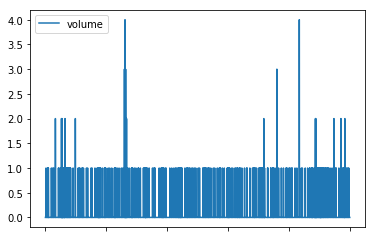

In [273]:
y.plot()

In [274]:
#del datX.a

# Scale the data

In [306]:
X.shape

(100000, 24)

In [307]:
y.shape

(100000, 1)

In [277]:
X

,volume_t-1,volume_t-2,volume_t-3,volume_t-4,volume_t-5,volume_t-6,volume_t-7,volume_t-8,volume_t-9,volume_t-10,...,volume_t-15,volume_t-16,volume_t-17,volume_t-18,volume_t-19,volume_t-20,volume_t-21,volume_t-22,volume_t-23,volume_t-24
2018-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [278]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = np.array(X)
X = scaler_X.fit_transform(X)

In [279]:
scaler_y = MinMaxScaler(feature_range=(0, 1))
y = np.array(y).reshape((len(y), 1))
y = scaler_y.fit_transform(y)

In [280]:
X.shape

(100000, 24)

In [281]:
y.shape

(100000, 1)

In [282]:
X.max()

1.0

In [283]:
y.max()

1.0

# Split the data into training and testing

In [284]:
n_train_rows = 50000

In [285]:
X_train = X[0 : n_train_rows, ]
X_test = X[n_train_rows:, ]

# Reshape
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

In [286]:
y_train = y[0 : n_train_rows]
y_test = y[n_train_rows:]

In [287]:
print(X_train.shape[0], "rows")
print(X_train.shape[1], "columns")
print(X_train.shape[2], "time lags")

50000 rows
24 columns
1 time lags


# The model

In [288]:
seed = 7

In [289]:
np.random.seed(seed)

In [290]:
model = Sequential()
model.add(LSTM(5, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='relu'))

model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(X_train, y_train, epochs=5, batch_size=50,
                    validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 50000 samples, validate on 50000 samples
Epoch 1/5
 - 17s - loss: 0.0014 - val_loss: 0.0011
Epoch 2/5
 - 18s - loss: 0.0014 - val_loss: 0.0011
Epoch 3/5
 - 19s - loss: 0.0014 - val_loss: 0.0011
Epoch 4/5
 - 17s - loss: 0.0014 - val_loss: 0.0011
Epoch 5/5
 - 18s - loss: 0.0014 - val_loss: 0.0011


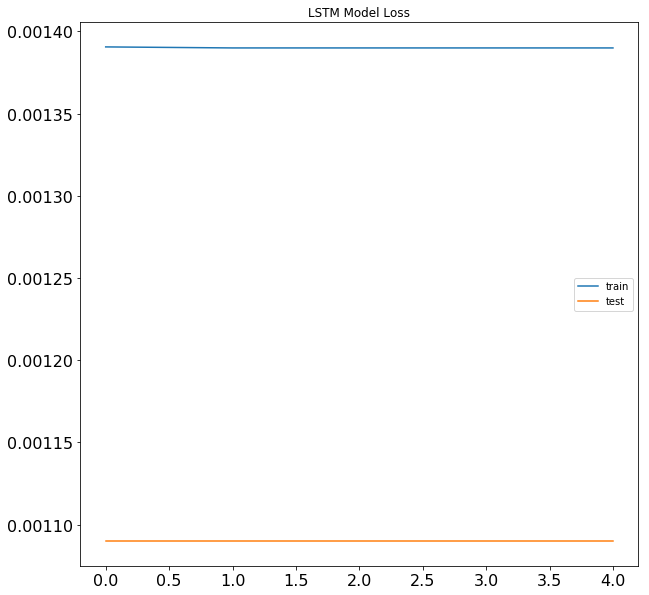

In [291]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [292]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [293]:
score_train = model.evaluate(X_train, y_train, batch_size=50)

50000/50000 [==============================] - 3s 56us/step


In [294]:
score_test = model.evaluate(X_test, y_test, batch_size=50)


50000/50000 [==============================] - 2s 49us/step


In [295]:
print("in train MSE = ", round(score_train, 4))

in train MSE =  0.0014


In [296]:
print("in test MSE ", round(score_test, 4))


in test MSE  0.0011


In [297]:
yhat = model.predict(X_test)

In [298]:
yhat = scaler_y.inverse_transform(np.array(yhat).reshape((len(yhat), 1)))

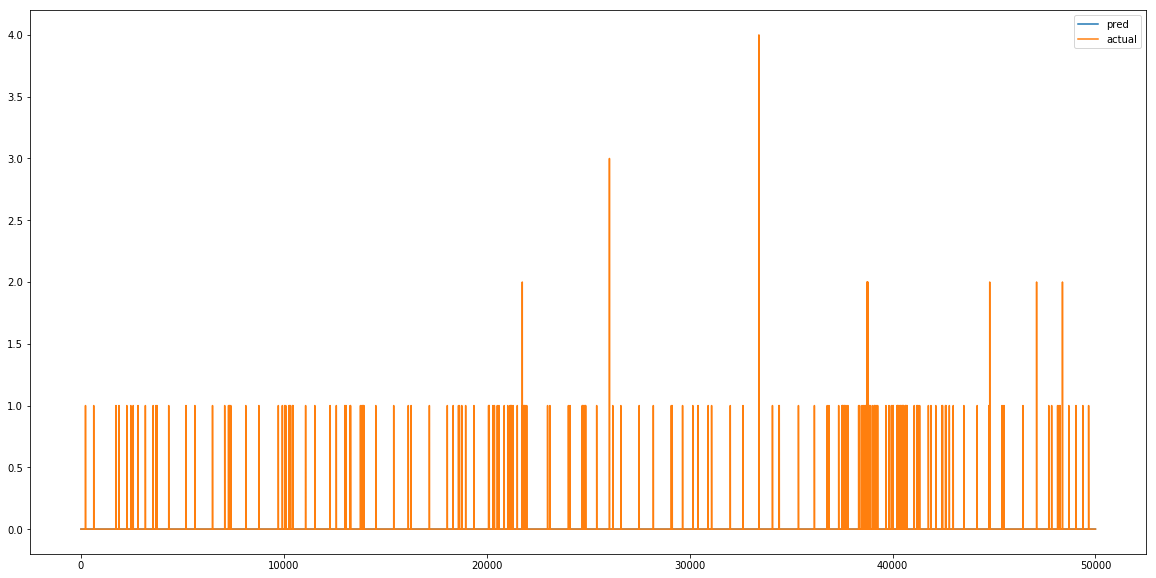

In [299]:
actual = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

results = pd.DataFrame()
results['pred'] = yhat[:,0]
results['actual'] = actual[:,0]
results.plot(figsize=(20,10))

In [300]:
# calculate r2
r2_score(actual, yhat)

-0.0038164297606355646

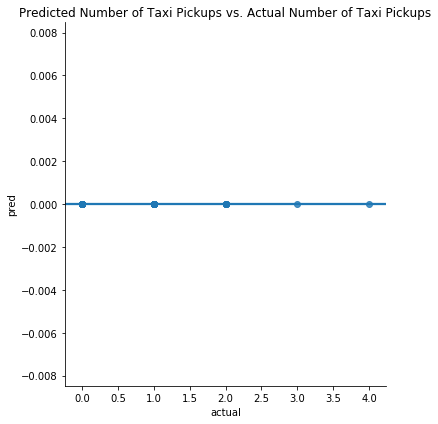

In [301]:
import seaborn as sns
sns.lmplot(x='actual',y='pred',data=results,fit_reg=True, size=6)
plt.title("Predicted Number of Taxi Pickups vs. Actual Number of Taxi Pickups")
plt.tight_layout()

In [303]:
results.describe()

,pred,actual
count,50000.0,50000.000000
mean,0.0,0.004360
std,0.0,0.070577
min,0.0,0.000000
25%,0.0,0.000000
50%,0.0,0.000000
75%,0.0,0.000000
max,0.0,4.000000
